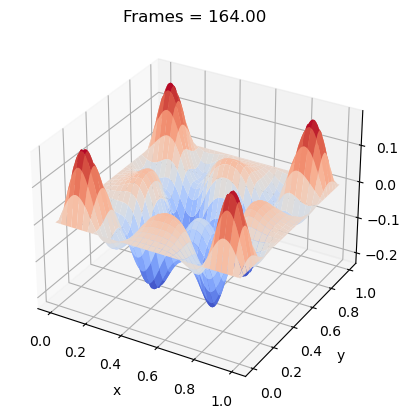

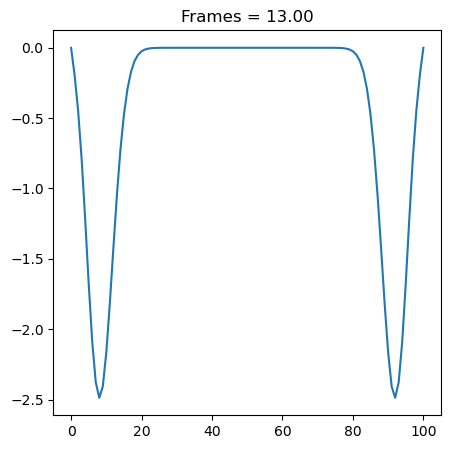

In [1]:
import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
from datetime import datetime

root = tk.Tk()
root.title("Wave Equations")

tab_control = ttk.Notebook(root)
tab1 = ttk.Frame(tab_control)
tab2 = ttk.Frame(tab_control)
tab_control.grid(column=0, row=0)

tab_control.add(tab1, text='1D Wave Equation')
tab_control.add(tab2, text='2D Wave Equation')

def wave1d():
    lf = ttk.LabelFrame(tab1, text="Set parameters")
    lf.grid(column=0, row=0, padx=10, pady=5)

    timeFrame = ttk.LabelFrame(tab1, text="Time screen")
    timeFrame.grid(column=0, row=1, padx=10, pady=5)

    controlFrame = ttk.LabelFrame(tab1, text="Control bar")
    controlFrame.grid(column=0, row=2, padx=10, pady=5, columnspan=2)

    L = tk.DoubleVar(value=10.0)
    c = tk.DoubleVar(value=1.0)
    T = tk.DoubleVar(value=5.0)
    dx = tk.DoubleVar(value=0.1)
    dt = tk.DoubleVar(value=0.05)

    L_label = tk.Label(lf, text="L:")
    L_entry = tk.Entry(lf, textvariable=L)

    c_label = tk.Label(lf, text="c:")
    c_entry = tk.Entry(lf, textvariable=c)

    T_label = tk.Label(lf, text="T:")
    T_entry = tk.Entry(lf, textvariable=T)

    dx_label = tk.Label(lf, text="dx:")
    dx_entry = tk.Entry(lf, textvariable=dx)

    dt_label = tk.Label(lf, text="dt:")
    dt_entry = tk.Entry(lf, textvariable=dt)

    Nx = int(L.get() / dx.get()) + 1
    Nt = int(T.get() / dt.get()) + 1

    block_size = 512

    u = np.zeros((Nt, Nx))

    gammasqr = (c.get() * dt.get() / dx.get())**2

    def update_parameters():
        nonlocal Nx, Nt, gammasqr, y_0, y_1, y, dev_y_0, dev_y_1, dev_y, threads_per_block, blocks_per_grid
        Nx = int(L.get() / dx.get()) + 1
        Nt = int(T.get() / dt.get()) + 1

        gammasqr = (c.get() * dt.get() / dx.get()) ** 2

        y_0 = np.zeros(Nx)
        y_1 = np.zeros(Nx)
        y = np.zeros(Nx)

        x = np.zeros(Nx)

        for i in range(Nx):
            x[i] = i * dx.get()

        y_0 = 5 * np.exp(-((np.arange(Nx) * dx.get() - 5) / 0.5) ** 2)

        for i in range(1, Nx - 1):
            y_1[i] = y_0[i] + 0.5 * gammasqr * (y_1[i + 1] - 2 * y_1[i] + y_1[i - 1])
        y[0] = y[Nx - 1] = 0

        u[0] = y_0 
        u[1] = y_1

        dev_y_0 = cuda.mem_alloc(y_0.nbytes)
        dev_y_1 = cuda.mem_alloc(y_1.nbytes)
        dev_y = cuda.mem_alloc(y.nbytes)

        cuda.memcpy_htod(dev_y_0, y_0)
        cuda.memcpy_htod(dev_y_1, y_1)

        threads_per_block = (block_size, 1, 1)
        blocks_per_grid = ((Nx + threads_per_block[0] - 1) // threads_per_block[0], 1)

    update_button = tk.Button(lf, text="Update Parameters", command=update_parameters)

    start_button = tk.Button(controlFrame, text="Start", command=lambda: ani.event_source.start())
    stop_button = tk.Button(controlFrame, text="Stop", command=lambda: ani.event_source.stop())

    L_label.grid(row=0, column=0, sticky="W")
    L_entry.grid(row=0, column=1)

    c_label.grid(row=2, column=0, sticky="W")
    c_entry.grid(row=2, column=1)

    T_label.grid(row=3, column=0, sticky="W")
    T_entry.grid(row=3, column=1)

    dx_label.grid(row=4, column=0, sticky="W")
    dx_entry.grid(row=4, column=1)

    dt_label.grid(row=6, column=0, sticky="W")
    dt_entry.grid(row=6, column=1)

    update_button.grid(row=7, column=0, columnspan=2)

    start_button.grid(row=0, column=0, padx=20)
    stop_button.grid(row=0, column=1, padx=20)

    fig = plt.figure(figsize=(5, 5))

    canvasFrame = ttk.LabelFrame(tab1, text="Result")
    canvasFrame.grid(row=0, column=2, padx=10, pady=10, rowspan=2)

    canvas = FigureCanvasTkAgg(fig, master=canvasFrame)
    canvas.get_tk_widget().grid(row=0, column=0)

    text = tk.Text(timeFrame, width=25, height=5)
    text.grid(row=0, column=0)

    mod = SourceModule("""

    __global__ void calc(double* d_y0, double* d_y1, double* d_y,
        const double gammasqr, const int N)
    {
        int idx = threadIdx.x + blockDim.x * blockIdx.x;

        if (idx < 0 || idx > N - 1) return;

        if (idx == 0 || idx == N - 1) {
            d_y[idx] = 0.0;
        }
        else {
            d_y[idx] = 2 * d_y1[idx] - d_y0[idx] + gammasqr * (d_y1[idx + 1] - 2 * d_y1[idx] + d_y1[idx - 1]);
        }
    }
    """)

    calc_kernel = mod.get_function("calc")

    y_0 = np.zeros(Nx, dtype=np.float64)
    y_1 = np.zeros(Nx, dtype=np.float64)
    y = np.zeros(Nx, dtype=np.float64)

    y_1 = 5 * np.exp(-((np.arange(Nx) * dx.get() - 5) / 0.5) ** 2)

    for i in range(1, Nx - 1):
        y[i] = y_1[i] + 0.5 * gammasqr * (y_1[i + 1] - 2 * y_1[i] + y_1[i - 1])
    y[0] = y[Nx - 1] = 0

    u[0] = y_1 
    u[1] = y

    y_0 = np.copy(y_1)
    y_1 = np.copy(y)

    dev_y_0 = cuda.mem_alloc(y_0.nbytes)
    dev_y_1 = cuda.mem_alloc(y_1.nbytes)
    dev_y = cuda.mem_alloc(y.nbytes)

    cuda.memcpy_htod(dev_y_0, y_0)
    cuda.memcpy_htod(dev_y_1, y_1)
    cuda.memcpy_htod(dev_y, y)

    threads_per_block = (block_size, 1, 1)
    blocks_per_grid = ((Nx + threads_per_block[0] - 1) // threads_per_block[0], 1)
    
    total_millis = 0;

    def solve_and_update(frame):
        nonlocal total_millis
        
        plt.clf()
        plt.title('Frames = {:.2f}'.format(frame))
        
        start = datetime.now()
        calc_kernel(dev_y_0, dev_y_1, dev_y, np.float64(gammasqr), np.int32(Nx), block=threads_per_block, grid=blocks_per_grid)

        cuda.memcpy_dtod(dev_y_0, dev_y_1, y_1.nbytes)
        cuda.memcpy_dtod(dev_y_1, dev_y, y.nbytes)
        cuda.memcpy_dtoh(y, dev_y)
        end = datetime.now()
        elapsed_time = (end - start).total_seconds() * 1000;
        total_millis += elapsed_time

        if frame == Nt - 2:
            text.insert(1.0, str(total_millis / 1000.0) + " seconds")
        
        u[frame] = y

        plt.plot(u[frame])

        return plt
    
    ani = FuncAnimation(fig, solve_and_update, frames=u.shape[0] - 1, interval=50, repeat=True)


def wave2d():
    lf = ttk.LabelFrame(tab2, text="Set parameters")
    lf.grid(column=0, row=0, padx=10, pady=5)

    timeFrame = ttk.LabelFrame(tab2, text="Time screen")
    timeFrame.grid(column=0, row=1, padx=10, pady=5)

    controlFrame = ttk.LabelFrame(tab2, text="Control bar")
    controlFrame.grid(column=0, row=2, padx=10, pady=5, columnspan=2)

    Lx = tk.DoubleVar(value=1.0)
    Ly = tk.DoubleVar(value=1.0)
    c = tk.DoubleVar(value=1.0)
    T = tk.DoubleVar(value=1.0)
    dx = tk.DoubleVar(value=0.01)
    dy = tk.DoubleVar(value=0.01)
    dt = tk.DoubleVar(value=0.005)

    Lx_label = tk.Label(lf, text="Lx:")
    Lx_entry = tk.Entry(lf, textvariable=Lx)

    Ly_label = tk.Label(lf, text="Ly:")
    Ly_entry = tk.Entry(lf, textvariable=Ly)

    c_label = tk.Label(lf, text="c:")
    c_entry = tk.Entry(lf, textvariable=c)

    T_label = tk.Label(lf, text="T:")
    T_entry = tk.Entry(lf, textvariable=T)

    dx_label = tk.Label(lf, text="dx:")
    dx_entry = tk.Entry(lf, textvariable=dx)

    dy_label = tk.Label(lf, text="dy:")
    dy_entry = tk.Entry(lf, textvariable=dy)

    dt_label = tk.Label(lf, text="dt:")
    dt_entry = tk.Entry(lf, textvariable=dt)

    Nx = int(Lx.get() / dx.get()) + 1
    Ny = int(Ly.get() / dy.get()) + 1
    Nt = int(T.get() / dt.get()) + 1

    def update_parameters():
        nonlocal Nx, Ny, Nt, gammasqr, u_0, u_1, u_2, x, y, d_u_0, d_u_1, d_u_2, blocksPerGrid_x, blocksPerGrid_y, blocksPerGrid, grid, X, Y
        Nx = int(Lx.get() / dx.get()) + 1
        Ny = int(Ly.get() / dy.get()) + 1
        Nt = int(T.get() / dt.get()) + 1

        gammasqr = (c.get() * dt.get() / dx.get()) ** 2

        u_0 = np.zeros(Nx * Ny)
        u_1 = np.zeros(Nx * Ny)
        u_2 = np.zeros(Nx * Ny)

        x = np.zeros(Nx)
        y = np.zeros(Ny)

        for i in range(Nx):
            x[i] = i * dx.get()

        for j in range(Ny):
            y[j] = j * dy.get()

        for j in range(Ny):
            for i in range(Nx):
                u_0[j * Nx + i] = np.exp(-100 * (pow(x[i] - 0.5, 2) + pow(y[j] - 0.5, 2)))

        for j in range(1, Ny - 1):
            for i in range(1, Nx - 1):
                u_1[j * Nx + i] = u_0[j * Nx + i] + 0.5 * gammasqr * (u_0[(j + 1) * Nx + i] + u_0[(j - 1) * Nx + i] + u_0[j * Nx + i + 1] + u_0[j * Nx + i - 1] - 4 * u_0[j * Nx + i])
        u_1[0] = 0.0
        u_1[Nx - 1] = 0.0
        u_1[(Ny - 1) * Nx] = 0.0
        u_1[(Ny - 1) * Nx + Nx - 1] = 0.0

        d_u_0 = cuda.mem_alloc(u_0.nbytes)
        d_u_1 = cuda.mem_alloc(u_1.nbytes)
        d_u_2 = cuda.mem_alloc(u_2.nbytes)

        cuda.memcpy_htod(d_u_0, u_0)
        cuda.memcpy_htod(d_u_1, u_1)

        blocksPerGrid_x = int(np.ceil(Nx / threadsPerBlock[0]))
        blocksPerGrid_y = int(np.ceil(Ny / threadsPerBlock[1]))
        blocksPerGrid = (blocksPerGrid_x, blocksPerGrid_y)
        grid = (blocksPerGrid[0], blocksPerGrid[1])

        X, Y = np.meshgrid(x, y)

    update_button = tk.Button(lf, text="Update Parameters", command=update_parameters)

    start_button = tk.Button(controlFrame, text="Start", command=lambda: ani.event_source.start())
    stop_button = tk.Button(controlFrame, text="Stop", command=lambda: ani.event_source.stop())

    Lx_label.grid(row=0, column=0, sticky="W")
    Lx_entry.grid(row=0, column=1)

    Ly_label.grid(row=1, column=0, sticky="W")
    Ly_entry.grid(row=1, column=1)

    c_label.grid(row=2, column=0, sticky="W")
    c_entry.grid(row=2, column=1)

    T_label.grid(row=3, column=0, sticky="W")
    T_entry.grid(row=3, column=1)

    dx_label.grid(row=4, column=0, sticky="W")
    dx_entry.grid(row=4, column=1)

    dy_label.grid(row=5, column=0, sticky="W")
    dy_entry.grid(row=5, column=1)

    dt_label.grid(row=6, column=0, sticky="W")
    dt_entry.grid(row=6, column=1)

    update_button.grid(row=7, column=0, columnspan=2)

    start_button.grid(row=0, column=0, padx=20)
    stop_button.grid(row=0, column=1, padx=20)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    canvasFrame = ttk.LabelFrame(tab2, text="Result")
    canvasFrame.grid(row=0, column=2, padx=10, pady=10, rowspan=2)

    canvas = FigureCanvasTkAgg(fig, master=canvasFrame)
    canvas.get_tk_widget().grid(row=0, column=0)

    text = tk.Text(timeFrame, width=25, height=5)
    text.grid(row=0, column=0)

    gammasqr = (c.get() * dt.get() / dx.get()) ** 2

    mod = SourceModule("""
        __global__ void solveWaveEquation(double* u_0, double* u_1, double* u_2, const int Nx, const int Ny, const double gammasqr) {
            int i = blockIdx.x * blockDim.x + threadIdx.x;
            int j = blockIdx.y * blockDim.y + threadIdx.y;
            if (i >= 0 && i < Nx && j >= 0 && j < Ny) {
                if (i > 0 && i < Nx - 1 && j > 0 && j < Ny - 1) {
                    u_2[j * Nx + i] = 2 * u_1[j * Nx + i] - u_0[j * Nx + i] + gammasqr * (u_1[(j + 1) * Nx + i] - 4 * u_1[j * Nx + i] + u_1[(j - 1) * Nx + i] + u_1[j * Nx + i + 1] + u_1[j * Nx + i - 1]);
                }

                if (i == 0 || i == Nx - 1 || j == 0 || j == Ny - 1) {
                    int idx = j * Nx + i;
                    u_2[idx] = 0.0;
                }
            }
        }
    """)

    solveWaveEquation = mod.get_function("solveWaveEquation")
    u_0 = np.zeros(Nx * Ny)
    u_1 = np.zeros(Nx * Ny)
    u_2 = np.zeros(Nx * Ny)

    x = np.zeros(Nx)
    y = np.zeros(Ny)

    for i in range(Nx):
        x[i] = i * dx.get()

    for j in range(Ny):
        y[j] = j * dy.get()

    for j in range(Ny):
        for i in range(Nx):
            u_0[j * Nx + i] = np.exp(-100 * (pow(x[i] - 0.5, 2) + pow(y[j] - 0.5, 2)))

    for j in range(1, Ny - 1):
        for i in range(1, Nx - 1):
            u_1[j * Nx + i] = u_0[j * Nx + i] + 0.5 * gammasqr * (u_0[(j + 1) * Nx + i] + u_0[(j - 1) * Nx + i] + u_0[j * Nx + i + 1] + u_0[j * Nx + i - 1] - 4 * u_0[j * Nx + i])
    u_1[0] = 0.0
    u_1[Nx - 1] = 0.0
    u_1[(Ny - 1) * Nx] = 0.0
    u_1[(Ny - 1) * Nx + Nx - 1] = 0.0

    d_u_0 = cuda.mem_alloc(u_0.nbytes)
    d_u_1 = cuda.mem_alloc(u_1.nbytes)
    d_u_2 = cuda.mem_alloc(u_2.nbytes)

    cuda.memcpy_htod(d_u_0, u_0)
    cuda.memcpy_htod(d_u_1, u_1)

    threadsPerBlock = (512, 2)
    blocksPerGrid_x = int(np.ceil(Nx / threadsPerBlock[0]))
    blocksPerGrid_y = int(np.ceil(Ny / threadsPerBlock[1]))
    blocksPerGrid = (blocksPerGrid_x, blocksPerGrid_y)
    block = (threadsPerBlock[0], threadsPerBlock[1], 1)
    grid = (blocksPerGrid[0], blocksPerGrid[1])
    
    total_millis = 0
    
    def solve_and_update(frame):
        nonlocal total_millis
        
        ax.clear()
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('u')
        ax.set_title('Frames = {:.2f}'.format(frame))

        if frame == 0:
            surf = ax.plot_surface(X, Y, u_0.reshape((Nx, Ny)), cmap='coolwarm')
            return surf,
        elif frame == 1:
            surf = ax.plot_surface(X, Y, u_1.reshape((Nx, Ny)), cmap='coolwarm')
            return surf,

        start = datetime.now()
        solveWaveEquation(d_u_0, d_u_1, d_u_2, np.int32(Nx), np.int32(Ny), np.float64(gammasqr), block=block, grid=grid)

        cuda.memcpy_dtod(d_u_0, d_u_1, u_1.nbytes)
        cuda.memcpy_dtod(d_u_1, d_u_2, u_2.nbytes)

        cuda.memcpy_dtoh(u_2, d_u_2)
        end = datetime.now()
        elapsed_time = (end - start).total_seconds() * 1000;
        total_millis += elapsed_time

        if frame == Nt - 2:
            text.insert(1.0, str(total_millis / 1000) + " seconds")
            
        surf = ax.plot_surface(X, Y, u_2.reshape((Nx, Ny)), cmap='coolwarm')
        return surf,


    X, Y = np.meshgrid(x, y)

    ani = FuncAnimation(fig, solve_and_update, frames=Nt, interval=50, repeat=True)

wave2d()
wave1d()
    
root.mainloop()
